#  Preparing estimates of daily Covid cases in Devon

### Data availability

Data on Covid is available for the UK from https://coronavirus.data.gov.uk/details/download.  

* For England as a whole: daily case data is available (including people who have had at least one positive COVID-19 test result). In this, data are shown by the date the sample was taken from the person being tested. Definition at: https://coronavirus.data.gov.uk/metrics/doc/newCasesBySpecimenDate  

* For MSOAs: weekly case data is available, showing the number of new cases within a 7 day period. Definition at https://coronavirus.data.gov.uk/metrics/doc/newCasesBySpecimenDateRollingSum


### Script functionality
This script converts the weekly data showing the number of new positive test results in the last 7 day period into an estimate of the number of new cases each day.  

This conversion process includes the following steps:
* Shifting the data back in time by 6 days (to account for a testing lag)  
* Multiplying the data by a month-specific multiplier (to account for not all cases being picked up by testing)  
* Linearly interpolating from weekly to daily data 
* Smoothing the data  

Daily estimates of cases are calcualted for both Devon as a whole and each MSOA seperately.

2 issues with recorded positive case data:
1.	There is a lag between the time of a positive test result and the time of infection
2.	Tests do not pick up all positive cases

Can correct this by:
1.	Shifting positive test results back in time (based on data on lag between infection and positive result)
2.	Using a multiplier on the number of positive cases (based on data on the proportion of positive case results being picked up by tests)

In [405]:
## Set up python environment
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import os
import time
import datetime
from datetime import datetime, timedelta
import matplotlib.dates as mdates
import numpy as np  
import matplotlib.cm as cm
from csaps import csaps

# Define functions
################################################################
# Function which converts weekly values into daily values
# This takes the weekly total and divides by 7 and assigns each of
# the previous 7 days with this value
################################################################
def interpolate_weekly_to_daily (weekly_df, colname, smooth_factor):
    # Create dataframe with column containing all dates for range between which data is found across any MSOA
    dates =pd.DataFrame({'Date':pd.date_range(start = '2020-03-24', end = '2021-05-18', freq='D')})
    # Create list to store the new daily cases values
    # Populate it with one value. This corresponds to the first week for which there is data. Divide this by 7
    # and include it once, as other days it refers to are not included. 
    new_cases_ls =[(weekly_df[colname][0])/7]
    # Loop through each week, find 1/7th of the weekly values and add it to the list of values 7 times
    # these will be assigned to each day in the week (ending on the week date)
    for i in range(1, len(weekly_df)):
        cases_this_week = weekly_df[colname][i]
        date = weekly_df['Date'][i]
        cases_each_day_this_week = cases_this_week/7
        new_cases_ls.extend(repeat(cases_each_day_this_week, 7))
    # Create dataframe
    daily_df =pd.DataFrame({'Date':dates['Date'],
                       'ShiftedInfections':new_cases_ls})
    # Smooth data
    daily_df =smooth_with_cubic_splines(daily_df.copy(), smooth_factor)
    return daily_df

################################################################
# Function which shifts cases back in time 6 days
# This involves losing the first data values, and the last  dates
################################################################
def shift_cases(df, ndays):
    # Shift the cases back by 6 days
    df_corrected = pd.DataFrame({'Date':df['Date'].iloc[:-6].reset_index(drop=True),
                            'OriginalCases': df['Cases'].iloc[:-6].reset_index(drop=True),
                            'ShiftedCases':df['Cases'].iloc[6:].reset_index(drop = True)})
    return (df_corrected)

################################################################
# Function which applies multipliers based on the month
################################################################
def apply_multipliers(df):
    # Loop through rows in cases dataframe and check the month and year and then apply the correct multiplier
    # Save the results into a list
    df_multiplied = df.copy()
    infections= []
    for row in df.itertuples():
        month = row.Date.strftime("%b")
        year = row.Date.strftime("%Y")
        multiplier = multipliers_dict[month+year]
        infections.append(row.ShiftedCases * multiplier)

    # Add column to dataframe using the list
    df_multiplied['ShiftedInfections'] = infections
    
    return df_multiplied

################################################################
# Function which smooths data using CSAPS package
################################################################
def smooth_with_cubic_splines(df, smooth_factor):
    df = df.copy()
    case_data = df['ShiftedInfections'].values
    case_data_locations = np.array(list(range(0, len(case_data))))
    xi = np.linspace(case_data_locations[0], case_data_locations[-1], len(case_data))
    df['SmoothedShiftedInfections'] = csaps(case_data_locations, case_data, xi, smooth=smooth_factor)
    df['SmoothedShiftedInfections'].values[df['SmoothedShiftedInfections'] < 0] = 0
    return df

## Download COVID test data for the UK from government website

In [177]:
# Define url to get data from
new_url = 'https://api.coronavirus.data.gov.uk/v2/data?areaType=msoa&metric=newCasesBySpecimenDateRollingSum&metric&format=csv'
# Download data
df = pd.read_csv(new_url)

## Keep only data for MSOAs in Devon, and reformat
Use msoa_codes of msoas in devon to filter the data

In [364]:
weekly_cases_msoas =df.copy()

# rename column to MSOA11CD
weekly_cases_msoas.rename(columns={"areaCode": "MSOA11CD", "date": "Date"}, inplace = True)

# set MSOA codes as index
weekly_cases_msoas = weekly_cases_msoas.set_index('MSOA11CD', drop=True)

# Reverse order of data (was starting from most recent date)
weekly_cases_msoas = weekly_cases_msoas.iloc[::-1]

# Convert to datetime (and then to just date)
weekly_cases_msoas['Date'] = pd.to_datetime(weekly_cases_msoas['Date'], format='%Y-%m-%d').dt.date
# Order by date
weekly_cases_msoas.sort_values(by='Date', inplace =True)

######### Just devon
# Load csv containing codes of msoas in Devon
devon_msoa_codes =pd.read_csv("devon_msoa_codes.csv").set_index('MSOA11CD', drop=True,verify_integrity=True)

# Keep only MSOA codes in Devon
weekly_cases_msoas = weekly_cases_msoas.join(other=devon_msoa_codes, how="inner")

# Keep only relevant columns
weekly_cases_msoas = weekly_cases_msoas[['Date', 'newCasesBySpecimenDateRollingSum']]

# Convert to datetime
weekly_cases_msoas['Date'] = pd.to_datetime(weekly_cases_msoas['Date'])

# Sort by date (again!)
weekly_cases_msoas.sort_values(by='Date', inplace =True)
weekly_cases_msoas.head()

,Date,newCasesBySpecimenDateRollingSum
MSOA11CD,,
E02004204,2020-03-25,3
E02004193,2020-03-25,3
E02004160,2020-04-01,6
E02004140,2020-04-01,3
E02004162,2020-04-01,3


### Convert format
Previous format: 2 columns, one with dates, one with cases numbers, MSOA code as index  
New format: One column with date, column for each MSOA containing cases numbers on each date

In [365]:
# Create dataframe containing the dates for which there are data in at least one MSOA
# dates = pd.DataFrame({'Date':weekly_cases_msoas['Date'].unique()})
# CReate dataframe containing all dates that exist in this timeframe (to take account for fact some weeks 
# have no cases in ANY of the msoas)
dates =pd.DataFrame({'Date':pd.date_range(start = '2020-03-25', end = '2021-05-19', freq='W-Wed')})

# Create list to store dataframe for each MSOA
list_dfs = []
# Loop through MSOAs and convert the format into a dataframe with a column for dates and a column for case values in that MSOA
# Join it to the list of dates with data in any MSOA
# Add to list of dataframes
for msoa_code in weekly_cases_msoas.index.unique().values:
    # get data for just one MSOA
    one_msoa = weekly_cases_msoas[weekly_cases_msoas.index ==msoa_code ]
    #print(one_msoa)
    # Create column as well as index (needed in pivot?)
    one_msoa.reset_index(level=0, inplace=True)
    # Pivot the format of the data so...
    piv = one_msoa.pivot(index = 'MSOA11CD', columns = 'Date')['newCasesBySpecimenDateRollingSum']
    # Transpose it so...
    piv_t = piv.T
    piv_t.reset_index(drop = False, inplace = True)
    # Join to dates
    piv_t = pd.merge(dates, piv_t, on=["Date"], how = 'left')
    if not list_dfs:
        list_dfs.append(piv_t)
    else:
        list_dfs.append(piv_t[msoa_code])
        
# Join list of dataframes into one        
weekly_cases_msoas = pd.concat(list_dfs, axis=1)
# Sort by date
weekly_cases_msoas.sort_values(by='Date', inplace =True)
# reindex
weekly_cases_msoas = weekly_cases_msoas.reset_index(drop = True)
weekly_cases_msoas.head()

,Date,E02004204,E02004193,E02004160,E02004140,E02004162,E02004151,E02004219,E02004202,E02004233,...,E02004200,E02004178,E02004224,E02004228,E02004129,E02004185,E02004135,E02004232,E02004212,E02004225
0,2020-03-25,3.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-04-01,NaN,5.0,6.0,3.0,3.0,3.0,3.0,3.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-04-08,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-04-15,NaN,4.0,4.0,NaN,NaN,4.0,NaN,3.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-04-22,NaN,NaN,4.0,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Replace NaNs with 0
This is where individual MSOAs didn't have data for some of the dates in the period

In [366]:
weekly_cases_msoas = weekly_cases_msoas.fillna(0)

#### Plot data - For each of the MSOAs individually (for a sample of the MSOAs)

In [359]:
# msoa_codes = weekly_cases_msoas.columns[1:]
# fig, axs = plt.subplots(figsize =(30,15), nrows=5, ncols=3, sharey=False)
# for i, ax in enumerate(fig.axes):
#     msoa_code = msoa_codes[i]
#     one_msoa = weekly_cases_msoas[['Date', msoa_code]]
       
#     ax.plot(one_msoa['Date'], one_msoa[msoa_code], label="Weekly (daily)", color="blue")
#     #ax.set_xlabel("Date", fontsize= 16)
#     #ax.set_xlabel("Date", fontsize= 16)
#     ax.tick_params(axis='x', labelrotation=45, labelsize = 20 )
#     ax.legend()
# plt.suptitle("Comparing weekly data with weekly sums from daily data")
# fig.tight_layout()
# plt.show()

## Interpolate from weekly to daily data

In [368]:
# Define how much to smooth the data - the CLOSER to 1 the LESS the data is smoothed
smooth_factor =0.9

################################################################
# Loop through each MSOA, extract the data for that MSOA and 
# use the function (defined at top of script) to interpolate from weekly to daily data
################################################################
# Create lists to store each MSOA dataframe from loop
interpolated_dfs = []
# Loop
for msoa_code in msoa_codes:
    # Take just one msoa's data, and format
    one_msoa = weekly_cases_msoas[['Date', msoa_code]]
    # Interpolate cases from weekly to 0
    one_msoa_interpolated = interpolate_weekly_to_daily(one_msoa, msoa_code, smooth_factor)
    # Set values <0 to 0
    one_msoa_interpolated['SmoothedShiftedInfections'].values[one_msoa_interpolated['SmoothedShiftedInfections'] < 0] = 0
    # rename column for interpolated cases
    one_msoa_interpolated = one_msoa_interpolated.rename(columns={"SmoothedShiftedInfections":msoa_code})
    # Add to interpolated dataframe list (if first MSOA then also add the dates)
    if msoa_code == msoa_codes[0]:
        interpolated_dfs.append(one_msoa_interpolated[['Date',msoa_code]]) 
    else:
        interpolated_dfs.append(one_msoa_interpolated[[msoa_code]])           

# Join list of interpolated dataframes into one      
daily_cases_msoas = pd.concat(interpolated_dfs, axis=1)

################################################################
# Plot for some MSOAs
################################################################
# msoa_codes = weekly_cases_msoas.columns[1:]
# fig, axs = plt.subplots(figsize =(30,15), nrows=5, ncols=3, sharey=False)
# for i, ax in enumerate(fig.axes):
#     msoa_code = msoa_codes[i]
#     one_msoa = daily_cases_msoas[['Date', msoa_code]]
#     ax.plot(one_msoa['Date'], one_msoa[msoa_code], label="Weekly (daily)", color="blue")
#     ax.tick_params(axis='x', labelrotation=45, labelsize = 20 )
#     ax.legend()
# plt.suptitle("Comparing weekly data with weekly sums from daily data")
# fig.tight_layout()
# plt.show()

## Shift and multiply data

In [406]:
smooth_factor=0.8

# Create lists to store each MSOA dataframe from loop
shifted_dfs = []
shifted_mpld_dfs = []
shifted_mpld_smoothed_dfs = []

# Loop through each MSOA, extract data for just that MSOA
# shift cases, multiply cases and save to lists (to convert 
# later back into one dataframe with just shfited data and 
# one with just multiplied data - one column per MSOA)
for msoa_code in msoa_codes:
    # Take just one msoa's data, and format
    one_msoa = daily_cases_msoas[['Date', msoa_code]]
    one_msoa = one_msoa.rename(columns={msoa_code:'Cases'})
    one_msoa.reset_index(drop = True, inplace = True)
    # # Shift cases
    one_msoa_shifted = shift_cases(one_msoa, 6)
    # Multiply cases
    one_msoa_shifted_mpld = apply_multipliers(one_msoa_shifted)
    # Smooth cases
    one_msoa_shifted_mpld_smoothed = smooth_with_cubic_splines(one_msoa_shifted_mpld, smooth_factor)
    
    # rename column for shifted cases
    one_msoa_shifted = one_msoa_shifted.rename(columns={"ShiftedCases":msoa_code})
    one_msoa_shifted = one_msoa_shifted.drop(['OriginalCases'], axis=1)
    
    # rename column for shifted, multiplied cases
    one_msoa_shifted_mpld = one_msoa_shifted_mpld.rename(columns={"ShiftedInfections":msoa_code})
    one_msoa_shifted_mpld = one_msoa_shifted_mpld.drop(['ShiftedCases', 'OriginalCases'], axis=1)

    # rename column for shifted, multiplied, smoothed cases
    one_msoa_shifted_mpld_smoothed = one_msoa_shifted_mpld_smoothed.rename(columns={"SmoothedShiftedInfections":msoa_code})
    
    # Add to shifted dataframe list
    if not shifted_dfs:
        shifted_dfs.append(one_msoa_shifted[['Date',msoa_code]])
    else:
        shifted_dfs.append(one_msoa_shifted[[msoa_code]])

    # Add to multiplied dataframe list
    if not shifted_mpld_dfs:
        shifted_mpld_dfs.append(one_msoa_shifted_mpld[['Date',msoa_code]])
    else:
        shifted_mpld_dfs.append(one_msoa_shifted_mpld[[msoa_code]])   

    # Add to smoothed dataframe list
    if not shifted_mpld_smoothed_dfs:
        shifted_mpld_smoothed_dfs.append(one_msoa_shifted_mpld_smoothed[['Date',msoa_code]])
    else:
        shifted_mpld_smoothed_dfs.append(one_msoa_shifted_mpld_smoothed[[msoa_code]])      
        
# Join list of dataframes into one - shifted       
daily_cases_msoas_shifted = pd.concat(shifted_dfs, axis=1)
# Join list of dataframes into one - multiplied        
daily_cases_msoas_shifted_mpld = pd.concat(shifted_mpld_dfs, axis=1)
# Join list of dataframes into one - multiplied        
daily_cases_msoas_shifted_mpld_smoothed = pd.concat(shifted_mpld_smoothed_dfs, axis=1)

# Remove bottom six rows so same length as shifted data
# daily_cases_msoas = daily_cases_msoas[:-6]

### Plot the number of cases over time for original case data and time shifted case data
#### Add subplot to this showing that multipliying is working correctly

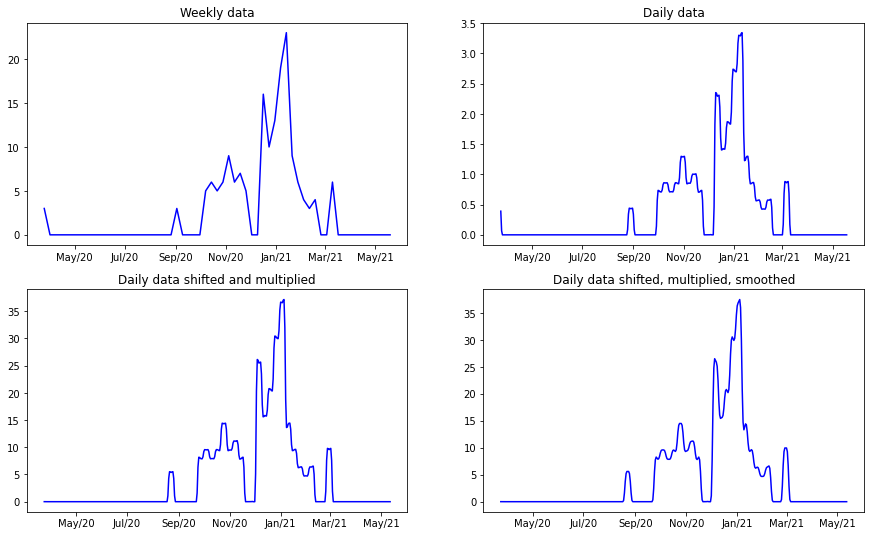

In [408]:
# Define formatting for dates
# myFmt = mdates.DateFormatter('%b/%y')
msoa_code = msoa_codes[0]
# # Plotting
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import StrMethodFormatter

fig, ax = plt.subplots(figsize =(15,9), sharey= False)
ax.axis('off')
ax1 = fig.add_subplot(221)
ax1.plot(weekly_cases_msoas['Date'], weekly_cases_msoas[msoa_code], label="Original cases", color="blue")
ax1.title.set_text('Weekly data')
ax1.xaxis.set_major_formatter(myFmt)

ax2 = fig.add_subplot(222)
ax2.plot(daily_cases_msoas['Date'], daily_cases_msoas[msoa_code], label="Original cases", color="blue")
ax2.title.set_text('Daily data')
ax2.xaxis.set_major_formatter(myFmt)

ax3 = fig.add_subplot(223)
ax3.plot(daily_cases_msoas_shifted_mpld['Date'], daily_cases_msoas_shifted_mpld[msoa_code], label="Original cases", color="blue")
ax3.title.set_text('Daily data shifted and multiplied')
ax3.xaxis.set_major_formatter(myFmt)

ax4 = fig.add_subplot(224)
ax4.plot(daily_cases_msoas_shifted_mpld_smoothed['Date'], daily_cases_msoas_shifted_mpld_smoothed[msoa_code], label="Original cases", color="blue")
ax4.title.set_text('Daily data shifted, multiplied, smoothed')
ax4.xaxis.set_major_formatter(myFmt)
plt.show()


## Join data for whole of Devon

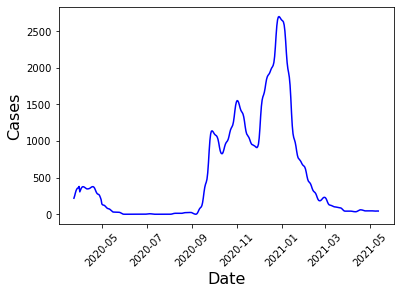

In [343]:
def find_devon_totals(df):
    totals_df = df.copy()
    # Add a row with the total number of cases across all MSOAs in each week
    totals_df['OriginalCases']= totals_df.iloc[:, 1:].sum(axis=1)
    # Remove columns with individual values for each MSOA
    totals_df = totals_df.drop(totals_df.iloc[:, 1:-1].columns, axis=1)
    totals_df.reset_index(inplace = True, drop = True)
    # Sort by date
    totals_df.sort_values(by='Date', inplace =True)
    return totals_df
    
daily_cases_devon_shifted_mltpld = find_devon_totals(daily_cases_msoas_shifted_mltpld) 

##################################################################################
# Plot
##################################################################################
# shared axis
fig, ax = plt.subplots()
plt.xlabel("Date", fontsize= 16)
plt.ylabel("Cases", fontsize= 16)
# plt.title("n")
plt.xticks(rotation=45)
plt.plot(daily_cases_devon_shifted_mltpld['Date'], daily_cases_devon_shifted_mltpld['OriginalCases'], label="Shifted cases", color="blue")


#### Plotting

In [340]:
# #Plotting
# fig, ax = plt.subplots(1, 1, figsize=(10, 5))
# ax.xaxis.set_major_formatter(myFmt)
# # Plot observations
# ax.plot(weekly_cases_devon['Date'], weekly_cases_devon['OriginalCases'], label="Original cases", color="orange")
# ax.plot(weekly_cases_devon_shifted['Date'], weekly_cases_devon_shifted['ShiftedCases'], label="Shifted cases", color="blue")
# ax.plot(weekly_cases_devon_shifted_mxpld['Date'], weekly_cases_devon_shifted_mxpld['ShiftedInfections'], label="Shifted infections", color="green")
# ax.plot(weekly_cases_devon_shifted_mxpld_smoothed['Date'], weekly_cases_devon_shifted_mxpld_smoothed['SmoothedShiftedInfections'], label="Shifted infections (smoothed)", color="purple")
# ax.plot(weekly_cases_devon_mxpld['Date'], weekly_cases_devon_mxpld['ShiftedInfections'], label="Not shifted infections", color="red")

# # Plot result from manually calibrated model
# #ax.plot(x, OpenCLRunner.get_cumulative_new_infections(summaries0), label="Initial sim", color="orange")
# ax.legend()
# ax.xaxis.set_major_formatter(myFmt)
# # plot_summaries(summaries=summaries_l[0], plot_type="error_bars", observations=OBSERVATIONS)
# plt.xlabel("Date")
# plt.ylabel("Cases")
# plt.show()

#### Remove values <0 (i.e. set them to 0)

In [17]:
# weekly_cases_devon_shifted_mxpld_smoothed['SmoothedShiftedInfections'].values[weekly_cases_devon_shifted_mxpld_smoothed['SmoothedShiftedInfections'] < 0] = 0

#### Save the corrected weekly case data to file

In [18]:
# # Save to file
# weekly_cases_devon_shifted_mxpld_smoothed = weekly_cases_devon_shifted_mxpld_smoothed.drop(['ShiftedInfections', 'ShiftedCases'], axis=1)
# weekly_cases_devon_shifted_mxpld_smoothed = weekly_cases_devon_shifted_mxpld_smoothed.rename(columns={'SmoothedShiftedInfections':'Cases'})
# weekly_cases_devon_shifted_mxpld_smoothed.to_csv("weekly_cases_devon_corrected.csv", index = False)

In [119]:
# # save shifted, multiplied, smoothed data
# weekly_cases_msoas_shifted_mltpld_smoothed.to_csv("weekly_cases_msoas_corrected.csv", index= False, float_format='%6g')
# # save shifted, multiplied, smoothed, interpolated data
# daily_cases_msoas_shifted_mltpld_smoothed.to_csv("daily_cases_msoas_corrected.csv", index= False, float_format='%6g')